In [3]:
import pandas as pd
import bioframe as bf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from pathlib import Path
import seaborn as sns
plt.rcParams['pdf.fonttype']=42

In [4]:
print(f"""pandas version: {pd.__version__}
bioframe version: {bf.__version__}
numpy version: {np.__version__}
matplotlib version: {mpl.__version__}
seaborn version: {sns.__version__}
""".format())

pandas version: 1.5.3
bioframe version: 0.7.2
numpy version: 1.23.5
matplotlib version: 3.7.1
seaborn version: 0.13.1



## Fig 1A: GC-content of the human genome, 100kb bins, radial plot, Speckles

In [5]:
path_to_hg38_genome_fasta = "/project/bigdata_aktas/genomes/human/snakepipes/hg38/GRCh38_gencode_release29/genome_fasta/genome.fa"
path_to_4DNFI8HIU45G = "/project/bigdata_aktas/hts_data/4Dnucleome/4DNFI8HIU45G.bw"
path_to_4DNFIBY8G6RZ = "/project/bigdata_aktas/hts_data/4Dnucleome/4DNFIBY8G6RZ.bw"

def bin_gc_tsa(path_to_hg38_genome_fasta, path_to_4DNFI8HIU45G, path_to_4DNFIBY8G6RZ):
    path_to_hg38_100k_bins_coordinates_gc = Path("data/pre-processed/hg38_100k_bins_coordinates_gc.csv.gz")
    if path_to_hg38_100k_bins_coordinates_gc.exists():
        hg38_100k_bins_coordinates_gc = pd.read_csv(path_to_hg38_100k_bins_coordinates_gc)
    else:
        hg38 = bf.assembly_info("hg38")
        hg38_fasta = bf.load_fasta(path_to_hg38_genome_fasta)
        hg38_100k_bins = bf.binnify(hg38.chromsizes, 10**5)
        hg38_100k_bins['name'] = hg38_100k_bins.index
        
        # Load TSA-seq data
        son_tsa_seq_rep1 = path_to_4DNFI8HIU45G
        son_tsa_seq_rep2 = path_to_4DNFIBY8G6RZ
        
        son_tsa_seq_rep1_bf = pd.concat([bf.read_bigwig(son_tsa_seq_rep1, chrom, engine='pyBigWig') for chrom in hg38.chromnames[:24]], axis=0)
        son_tsa_seq_rep2_bf = pd.concat([bf.read_bigwig(son_tsa_seq_rep2, chrom, engine='pyBigWig') for chrom in hg38.chromnames[:24]], axis=0)
        # Calculate relative distance of each bin to Speckles, using SON TSA-seq data

        overlap1 = bf.overlap(hg38_100k_bins,
                              son_tsa_seq_rep1_bf).groupby('name').mean('value_')
        
        overlap2 = bf.overlap(hg38_100k_bins,
                              son_tsa_seq_rep2_bf).groupby('name').mean('value_')
        
        hg38_100k_bins_coordinates = pd.merge(hg38_100k_bins,
                     overlap1[['value_']].rename(columns={'value_':'SON_TSA_rep1'}),
                                            how='left',
                                            on='name'
                                           )
        
        hg38_100k_bins_coordinates = pd.merge(hg38_100k_bins_coordinates,
                     overlap2[['value_']].rename(columns={'value_':'SON_TSA_rep2'}),
                                            how='left',
                                            on='name'
                                           )
        
        hg38_100k_bins_coordinates['son_average_dist'] = (hg38_100k_bins_coordinates.SON_TSA_rep1 + hg38_100k_bins_coordinates.SON_TSA_rep2)/2
        hg38_100k_bins_coordinates['exp_son_average_dist'] = np.exp(-hg38_100k_bins_coordinates.son_average_dist)
        hg38_100k_bins_coordinates['exp_SON_TSA_rep1'] = np.exp(-hg38_100k_bins_coordinates.SON_TSA_rep1)
        hg38_100k_bins_coordinates['exp_SON_TSA_rep2'] = np.exp(-hg38_100k_bins_coordinates.SON_TSA_rep2)

        # Calculate GC-content of each bin
        hg38_100k_bins_coordinates_gc = bf.frac_gc(hg38_100k_bins_coordinates, hg38_fasta)
    
    return hg38_100k_bins_coordinates_gc

In [6]:
hg38_100k_bins_coordinates_gc = bin_gc_tsa(path_to_hg38_genome_fasta, path_to_4DNFI8HIU45G, path_to_4DNFIBY8G6RZ)

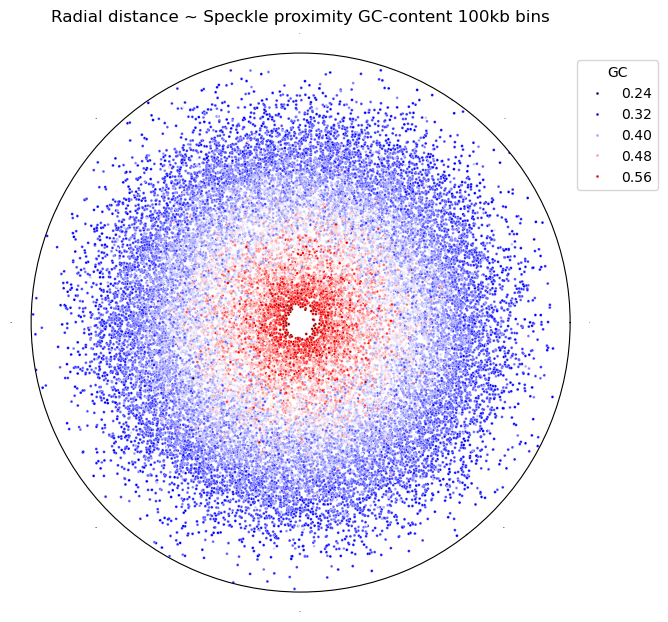

In [7]:
# Plot

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': 'polar'}, figsize=[7,7])

temp = hg38_100k_bins_coordinates_gc.dropna()

rng = np.random.default_rng(seed=42)
theta = rng.random(len(temp))*2*np.pi

ax = sns.scatterplot(x=theta,
                    y=temp.exp_son_average_dist,
                    s=4,
                    hue=temp.GC,
                    palette='seismic',
                    ax=ax
               )


ax.set_title("Radial distance ~ Speckle proximity GC-content 100kb bins", va='bottom')
ax.set_ylabel('')
ax.set_rticks([])  # Less radial ticks
ax.grid(False)
ax.tick_params(labelsize=0, width=0)
ax.set_rmax(2.5)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
plt.close()